# Import Library

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn import mixture
from sklearn import preprocessing
from scipy import interpolate
from collections import Counter
from importlib import reload

# Data Preprocess
### Reading data

In [103]:
def read_data(folder):
    data = pd.DataFrame()
    file = folder.split('_')[1]
    for i in range(1,304):
        file_path = "../data/50mph/" + str(folder) + "/" + str(folder) + "_Step" + str(i) + ".csv"
        tmp = pd.read_csv(file_path)
        force = np.sqrt(tmp["F_x"]**2 + 
                        tmp["F_y"]**2 + 
                        tmp["F_z"]**2)
        data[str(i)] = force
    data.insert(0, "part_num", tmp["part_num"])
    data.insert(1, "x", tmp["centroid_x"])
    data.insert(2, "y", tmp["centroid_y"])
    data.insert(3, "z", tmp["centroid_z"])
    
    return data

# folder = "cb_d16out"
# data = read_data(folder)

### Utility functions

In [29]:
def preprocess(df):
    min_value = 1e-5
    df.iloc[:,4:] = np.log(df.iloc[:,4:] + min_value)
    
    return df

def spline_validate(data, knots, labels, mask):
#     print(data)
    idx_train = [idx for idx, label in enumerate(labels) if label != mask]
    idx_val = [idx for idx, label in enumerate(labels) if label == mask]
    
    x_train = np.linspace(0, total_time, num = len(idx_train))
    y_train = data.iloc[idx_train]
    tck = interpolate.splrep(x_train, y_train, task = -1, k = 3, t = knots)
    
    x_val = [i * time_interval * record_per_step for i in idx_val]
    y_pred = interpolate.splev(x_val, tck)
    y_val = data.iloc[idx_val]
    
    return np.sum((y_pred - y_val)**2)

def get_spline_coef(data, knots):
    x = np.linspace(0, total_time, num = len(data))
    tck = interpolate.splrep(x, data, task = -1, k = 3, t = knots)
    
    return tck[1]

def util_winsorization(df):
    p = 0.95
    quantile_value = np.quantile(df, p)
    
    df = df.apply(lambda x: x if x < quantile_value else quantile_value)
    
    return df

def preprocess(df):
    # change movement into absolute values
    df.iloc[:,4:7] = np.abs(df.iloc[:,4:7])

    # take natural logarithm for movement columns
    min_value = 1e-5
    df.iloc[:,4:7] = np.log(df.iloc[:,4:7] + min_value)
    
    # winsorization is not suitable here, it actually makes the clustering results worse
#     df.iloc[:,4:7] = df.iloc[:,4:7].apply(util_winsorization, axis = 0)
    
    # data standardization 
    tmp = pd.DataFrame(preprocessing.scale(df.iloc[:,4:7]))
    tmp = tmp.set_index(pd.Index(range(len(df["part_num"]))))
    tmp.columns = df.columns[4:7]
    df.iloc[:,4:7] = tmp
    
    return df

### EDA (exploratory data analysis)

In [84]:
folder = "locs_d16out"
data = read_data(folder)

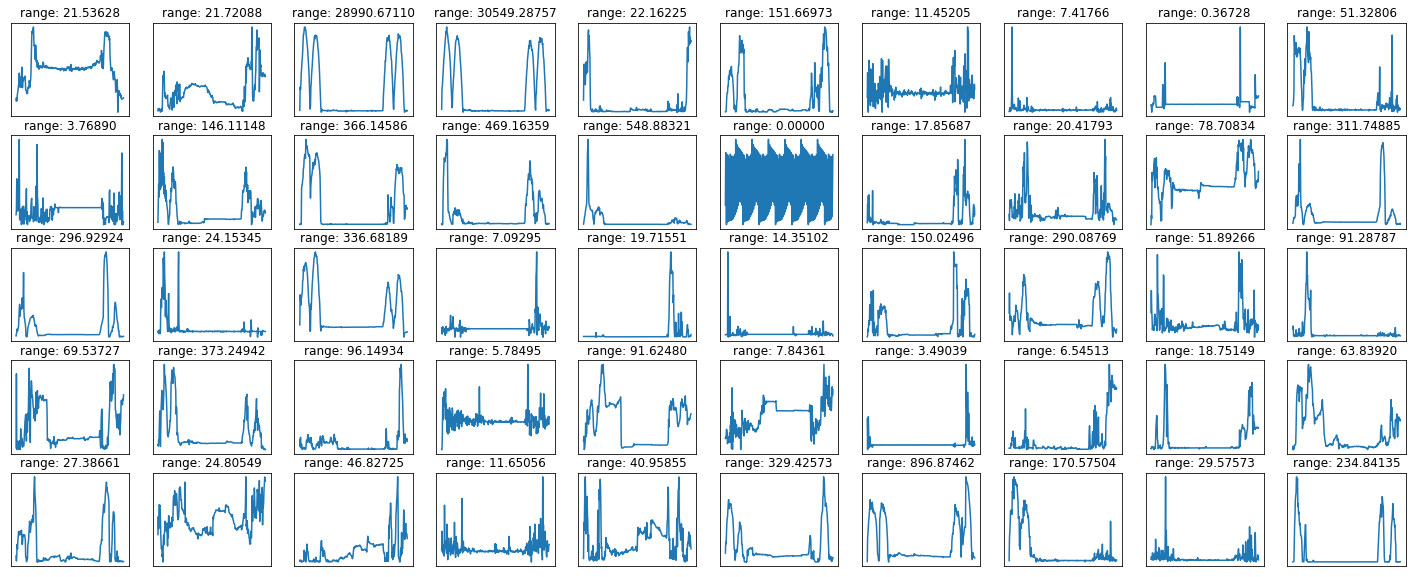

In [85]:
# show force change with time
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(50):
    ax = fig.add_subplot(5, 20/2, idx+1, xticks=[], yticks=[])
    ax.plot(data.iloc[idx,4:])
    force_range = max(data.iloc[idx,4:]) - min(data.iloc[idx,4:]) 
    ax.set_title("range: {0:.5f}".format(force_range))


# Spline Regression

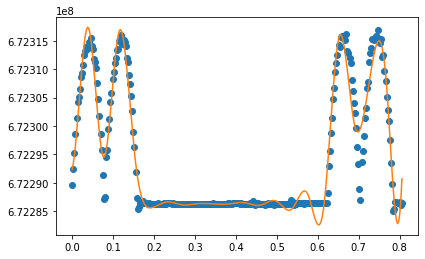

In [32]:
time_interval = 0.000002896586623472
record_per_step = 921
total_time = time_interval * record_per_step * 302

x = np.linspace(0, total_time, num = 303)
y = data.iloc[3, 4:]

knot_num = 20
knots = np.linspace(total_time * 1/(knot_num + 1), total_time * knot_num / (knot_num + 1), num = knot_num)

tck = interpolate.splrep(x, y, task = -1, k = 3, t = knots)
spline = interpolate.splev(x, tck)
xs = np.arange(0, 279639*time_interval, 0.1)

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(x, spline, label="S")

# tck
# https://en.wikipedia.org/wiki/De_Boor%27s_algorithm

### Choose knot number

knots number: 1, mask score:1754461.668869725
knots number: 2, mask score:1595546.6473377359
knots number: 3, mask score:1163370.8023022213
knots number: 4, mask score:1207545.1478288006
knots number: 5, mask score:1216680.1785860367
knots number: 6, mask score:1187715.2414751598
knots number: 7, mask score:1178002.083252795
knots number: 8, mask score:1193987.6447925852
knots number: 9, mask score:1151309.273879508
knots number: 10, mask score:1070606.4652851787
knots number: 11, mask score:984514.7756007193
knots number: 12, mask score:909452.0832995947
knots number: 13, mask score:797716.7511852687
knots number: 14, mask score:646968.1413006966
knots number: 15, mask score:526512.3947090147
knots number: 16, mask score:491170.3098366414
knots number: 17, mask score:514314.81778217107
knots number: 18, mask score:497844.5902459219
knots number: 19, mask score:404672.19267918274
knots number: 20, mask score:297867.1303701692
knots number: 21, mask score:240069.0711146572
knots number:

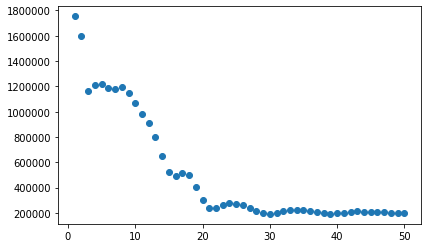

In [21]:
total_particle = len(data)
time_interval = 0.000002896586623472
record_per_step = 921
total_time = time_interval * record_per_step * 302

# divided into 10 groups for cross validation
labels = np.random.randint(1, 11, size = 303)

validation_score = []

for knot_num in range(1, 51):
    mask_score = []
    for mask in range(1, 11):
        knots = np.linspace(total_time * 1/(knot_num + 1), total_time * knot_num / (knot_num + 1), num = knot_num)
        row_score = data.iloc[:,4:].apply(lambda x: spline_validate(x, knots, labels, mask), axis=1)
        row_score_avg = np.mean(row_score)
        
        mask_score.append(row_score_avg)
        
    print("knots number: {}, mask score:{}".format(knot_num, np.mean(mask_score)))
    validation_score.append(np.mean(mask_score))

        
knots_range = np.linspace(1, 50, 50)

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(knots_range, validation_score, 'o', label='MSE')


### Calculate B-spline coefficients

In [104]:
folder = "locs_d10out"
data = read_data(folder)

knot_num = 20
knots = np.linspace(total_time * 1/(knot_num + 1), total_time * knot_num / (knot_num + 1), num = knot_num)

spline_coef = data.iloc[:,4:].apply(lambda x: get_spline_coef(x, knots), axis=1)
spline_coef_reshape = np.concatenate(spline_coef).reshape(-1,28)
spline_coef_reshape = pd.DataFrame(spline_coef_reshape)

spline_coef_reshape.insert(0, "part_num", data["part_num"])
spline_coef_reshape.to_csv('spline_coef_locs_10.csv',header=True, index=False)
spline_coef_reshape.head()

FileNotFoundError: [Errno 2] File b'../data/50mph/locs_d10out/locs_d10out_Step1.csv' does not exist: b'../data/50mph/locs_d10out/locs_d10out_Step1.csv'

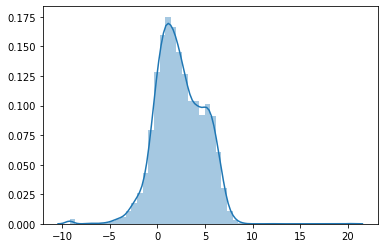

In [53]:
%matplotlib inline

# get a intuition of data distributions
sns.distplot(pd.DataFrame(np.log(np.abs(spline_coef_reshape.iloc[:,3])+0.0001)))
# np.log((spline_coef_reshape.iloc[:,3]))

# Clustering

In [97]:
data.head()

,part_num,x,y,z,1,2,3,4,5,6,...,294,295,296,297,298,299,300,301,302,303
0,1,0.579752,0.464981,0.218993,1.707857e+01,1.781289e+01,1.697879e+01,1.813798e+01,1.874027e+01,1.925556e+01,...,1.888619e+01,1.802282e+01,1.845724e+01,1.751722e+01,1.756644e+01,1.744365e+01,1.763591e+01,1.763559e+01,1.765374e+01,1.776315e+01
1,2,0.609779,0.527475,0.239596,1.287830e+00,1.842363e+00,1.532957e+00,1.584354e+00,1.848833e+00,1.478328e+00,...,1.066821e+01,9.990032e+00,1.068486e+01,1.098841e+01,1.042767e+01,1.043431e+01,1.014484e+01,1.062044e+01,1.001134e+01,1.000265e+01
2,3,0.703999,0.486192,0.222363,1.774727e+09,1.774735e+09,1.774734e+09,1.774736e+09,1.774740e+09,1.774741e+09,...,1.774728e+09,1.774726e+09,1.774726e+09,1.774727e+09,1.774727e+09,1.774727e+09,1.774727e+09,1.774727e+09,1.774727e+09,1.774727e+09
3,4,0.871685,0.463795,0.219024,1.774731e+09,1.774739e+09,1.774740e+09,1.774742e+09,1.774744e+09,1.774747e+09,...,1.774732e+09,1.774730e+09,1.774731e+09,1.774731e+09,1.774731e+09,1.774731e+09,1.774731e+09,1.774731e+09,1.774731e+09,1.774731e+09
4,5,1.054449,0.489266,0.261152,3.139027e+00,1.245982e+01,1.227701e+01,7.322978e+00,1.249601e+01,7.142812e+00,...,1.442297e+01,1.312323e+01,2.093496e+01,1.738699e+01,2.050903e+01,2.216225e+01,1.781855e+01,1.942231e+01,1.816341e+01,1.848144e+01


In [100]:
import visualization_util as vs

reload(vs)

spline_data = pd.read_csv('spline_coefficients.csv')
spline_data = preprocess(spline_data)
# unsuperised kmeans clustering
# kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(np.log(np.abs(spline_data.iloc[:,4:25])+0.0001))
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(spline_data.iloc[:,4:25])

# check clustering distribution
print(Counter(kmeans.labels_))

# # saving labels to csv file
tmp = [spline_data.iloc[idx,0] for idx, label in enumerate(kmeans.labels_) if label == 4]
# label = pd.DataFrame({'part_num':spline_data["part_num"],'label':kmeans.labels_})
label = pd.DataFrame({'part_num':tmp,'label':[4]*len(tmp)})
label.to_csv('labels_force_locs.csv',header=True, index=False)

# # # visualization
vs.plot('labels_force_locs.csv', 'LackofCenterSup.v3d','library.vlb')

Counter({0: 11020, 4: 380, 1: 2, 2: 2, 3: 1})
